In [20]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt

from calibrated_response.maxent_large.distribution_builder import DistributionBuilder
from calibrated_response.maxent_large.maxent_solver import JAXSolverConfig

from calibrated_response.models.variable import ContinuousVariable
from calibrated_response.models.query import (
    ProbabilityEstimate,
    ExpectationEstimate,
    ConditionalProbabilityEstimate,
    ConditionalExpectationEstimate,
    InequalityProposition,
)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1) Define Variables & Estimates

In [21]:
# --- Variables ---
variables = [
    ContinuousVariable(name="gdp_growth",    description="Annual GDP growth rate (%)", lower_bound=-2.0, upper_bound=8.0, unit="%"),
]

# --- Estimates (marginal + conditional cross-links) ---
estimates = [
    # Marginal: E[GDP growth] = 2.5%
    ExpectationEstimate(id="e_gdp", variable="gdp_growth", expected_value=2.5),
    # Marginal: P(GDP > 6%) = 0.45
    ProbabilityEstimate(
        id="p_gdp_high",
        proposition=InequalityProposition(variable="gdp_growth", 
                                          variable_type="continuous", 
                                          threshold=4.0, 
                                          is_lower_bound=True),
        probability=0.45,
    ),
]

print(f"{len(variables)} variables, {len(estimates)} estimates")

1 variables, 2 estimates


## 2) Build the MaxEnt Distribution

In [30]:
config = JAXSolverConfig(
    num_chains=256,
    num_iterations=500,
    mcmc_steps_per_iteration=4,
    learning_rate=0.006,

    l2_regularization=1e-4,

    hmc_step_size=0.015,
    hmc_leapfrog_steps=10,
    max_bins=15,
    seed=42,
    verbose=True,
    prior="gaussian",
)

builder = DistributionBuilder(variables=variables, estimates=estimates, solver_config=config)

# Build for GDP growth (the solver trains once; marginals for all variables are in info)
distribution, info = builder.build(target_variable="gdp_growth")

print(f"\nConverged: {info['converged']}")
print(f"Features used: {info['n_features']}")
print(f"Skipped: {info['skipped_constraints']}")

[MaxEntSolver] iter   50  max_err=0.073667  mean_err=0.063338  accept=0.945  step_size=0.17201
[MaxEntSolver] iter  100  max_err=0.082292  mean_err=0.062487  accept=0.509  step_size=0.32557
[MaxEntSolver] iter  150  max_err=0.065698  mean_err=0.064045  accept=0.659  step_size=0.27669
[MaxEntSolver] iter  200  max_err=0.059556  mean_err=0.058709  accept=0.659  step_size=0.25991
[MaxEntSolver] iter  250  max_err=0.067585  mean_err=0.052492  accept=0.733  step_size=0.22089
[MaxEntSolver] iter  300  max_err=0.066595  mean_err=0.051962  accept=0.657  step_size=0.22933
[MaxEntSolver] iter  350  max_err=0.070417  mean_err=0.046532  accept=0.644  step_size=0.19490
[MaxEntSolver] iter  400  max_err=0.089607  mean_err=0.048352  accept=0.560  step_size=0.20235
[MaxEntSolver] iter  450  max_err=0.065409  mean_err=0.049384  accept=0.653  step_size=0.21009
[MaxEntSolver] iter  500  max_err=0.055771  mean_err=0.049072  accept=0.700  step_size=0.19734

Converged: False
Features used: 2
Skipped: []


In [31]:
print(info['theta'])

[ 3.0150104 -2.0163403]


## 3) Training Diagnostics

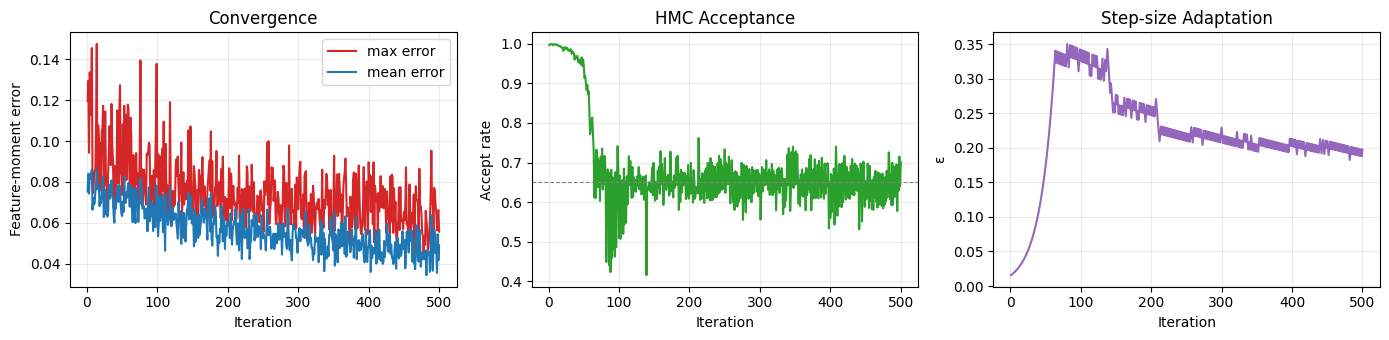

Final max error:  0.05577
Final mean error: 0.04907
Final accept rate: 0.700


In [32]:
history = info["history"]

fig, axes = plt.subplots(1, 3, figsize=(14, 3.5))

axes[0].plot(history["iteration"], history["max_error"], label="max error", color="C3")
axes[0].plot(history["iteration"], history["mean_error"], label="mean error", color="C0")
axes[0].set_xlabel("Iteration"); axes[0].set_ylabel("Feature-moment error")
axes[0].set_title("Convergence"); axes[0].legend(); axes[0].grid(alpha=0.25)

axes[1].plot(history["iteration"], history["accept_rate"], color="C2")
axes[1].axhline(config.target_accept_rate, ls="--", color="gray", lw=0.8)
axes[1].set_xlabel("Iteration"); axes[1].set_ylabel("Accept rate")
axes[1].set_title("HMC Acceptance"); axes[1].grid(alpha=0.25)

axes[2].plot(history["iteration"], history["step_size"], color="C4")
axes[2].set_xlabel("Iteration"); axes[2].set_ylabel("ε")
axes[2].set_title("Step-size Adaptation"); axes[2].grid(alpha=0.25)

plt.tight_layout(); plt.show()

print(f"Final max error:  {history['max_error'][-1]:.5f}")
print(f"Final mean error: {history['mean_error'][-1]:.5f}")
print(f"Final accept rate: {history['accept_rate'][-1]:.3f}")

In [33]:
# print(builder.solver._buffer.states)

import jax.numpy as jnp
energy = builder.solver._energy_fn
theta = info['theta']
# fv_fn = builder.solver._feature_vector_fn

# def energy(x):
#     return -jnp.dot(theta, fv_fn(x))

x = np.linspace(0, 1, 200)
x_e = jnp.array([energy(theta, xi) for xi in x.reshape(-1, 1)])

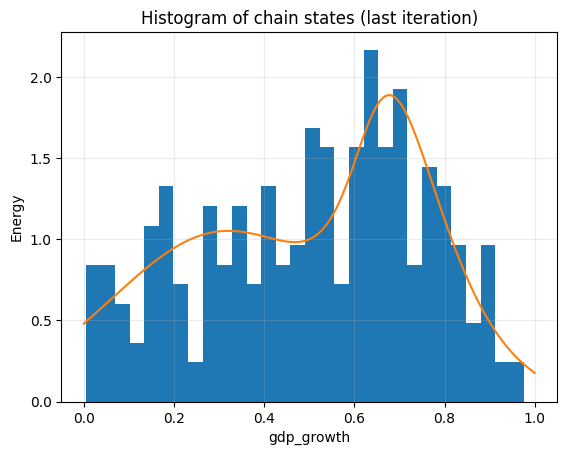

In [ ]:
px = jnp.exp(-x_e)
px = px / jnp.sum(px) * len(px)  # normalise

plt.plot(x, px, color="C1")
plt.xlabel("GDP Growth (%)"); plt.ylabel("Energy"); plt.title("Energy Function")

plt.hist(builder.solver._buffer.states[:, 0], bins=30, density=True)
plt.xlabel("gdp_growth"); plt.title("Histogram of chain states (last iteration)"); plt.grid(alpha=0.25); plt.show()

Text(0.5, 1.0, 'Energy Function')

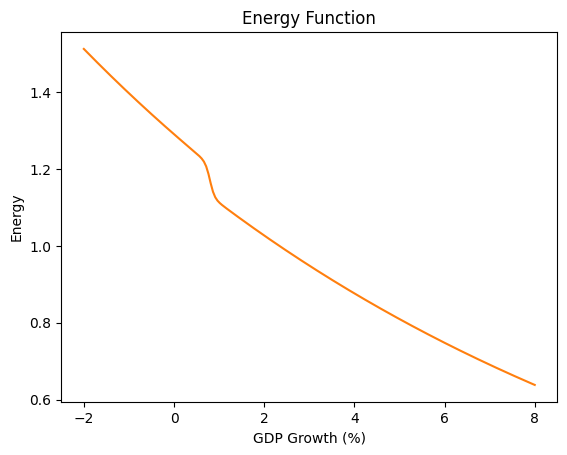

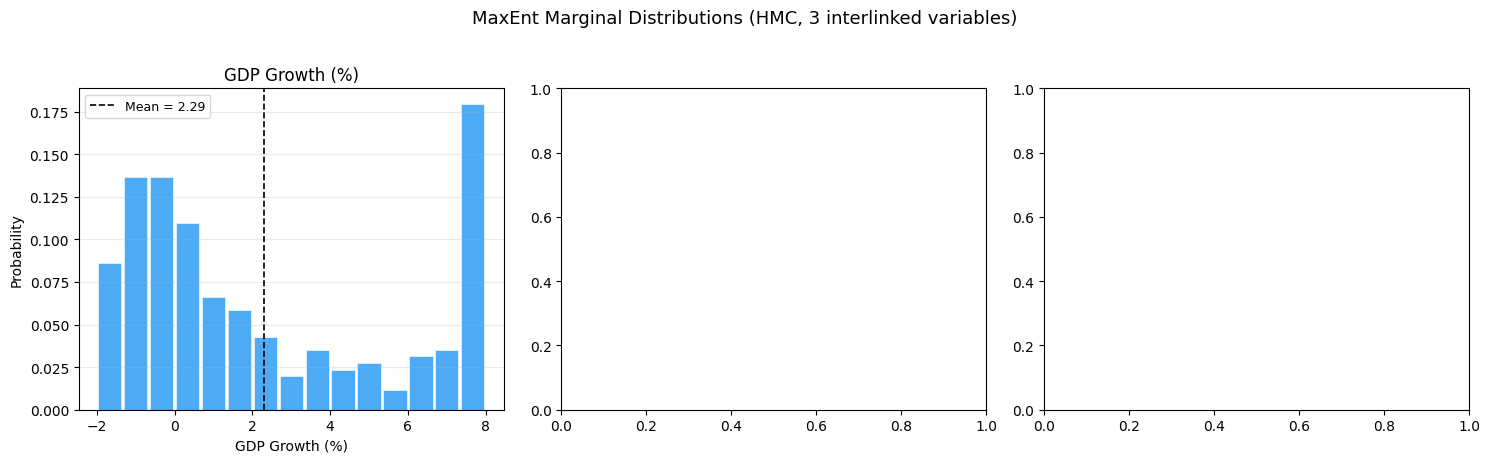

           GDP Growth (%):  mean = 2.29,  std = 3.36


In [6]:
all_marginals = builder.get_all_marginals(info)

colors = {"gdp_growth": "#2196F3", "unemployment": "#FF5722", "inflation": "#4CAF50"}
labels = {"gdp_growth": "GDP Growth (%)", "unemployment": "Unemployment Rate (%)", "inflation": "Inflation Rate (%)"}

fig, axes = plt.subplots(1, 3, figsize=(15, 4.5))

for ax, (name, dist) in zip(axes, all_marginals.items()):
    edges = np.array(dist.bin_edges)
    centers = (edges[:-1] + edges[1:]) / 2.0
    widths = edges[1:] - edges[:-1]
    probs = np.array(dist.bin_probabilities)

    ax.bar(centers, probs, width=widths * 0.9, color=colors[name], alpha=0.8, edgecolor="white", linewidth=0.5)

    # Mark the mean
    mean = float(np.dot(centers, probs))
    ax.axvline(mean, color="black", ls="--", lw=1.2, label=f"Mean = {mean:.2f}")

    ax.set_xlabel(labels[name])
    ax.set_ylabel("Probability")
    ax.set_title(labels[name])
    ax.legend(fontsize=9)
    ax.grid(axis="y", alpha=0.25)

plt.suptitle("MaxEnt Marginal Distributions (HMC, 3 interlinked variables)", fontsize=13, y=1.02)
plt.tight_layout()
plt.show()

# Print summary statistics
for name, dist in all_marginals.items():
    edges = np.array(dist.bin_edges)
    centers = (edges[:-1] + edges[1:]) / 2.0
    probs = np.array(dist.bin_probabilities)
    mean = float(np.dot(centers, probs))
    std = float(np.sqrt(np.dot(probs, (centers - mean) ** 2)))
    print(f"{labels[name]:>25s}:  mean = {mean:.2f},  std = {std:.2f}")

## 5) Pairwise Joint Scatter Plots

Visualize the cross-variable structure encoded by the conditional estimates by plotting samples from the persistent HMC chains.

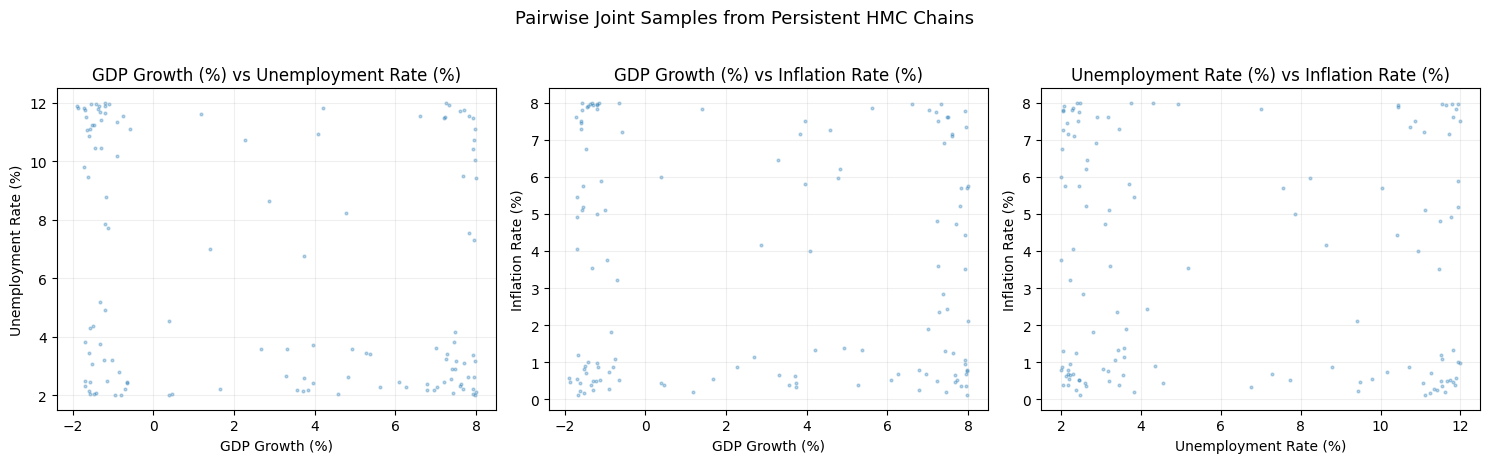

In [7]:
# --- Pairwise scatter plots from MCMC chains (original domain) ---
chain_states = info["chain_states"]  # (C, 3) in normalised [0,1]

# Denormalize back to original domains for plotting
from calibrated_response.maxent_large.normalizer import ContinuousDomainNormalizer
normalizer = ContinuousDomainNormalizer(variables)
chains_orig = np.zeros_like(chain_states)
for i, var in enumerate(variables):
    chains_orig[:, i] = np.array([normalizer.denormalize_value(var.name, float(v)) for v in chain_states[:, i]])

var_labels = [labels[v.name] for v in variables]
pairs = [(0, 1), (0, 2), (1, 2)]

fig, axes = plt.subplots(1, 3, figsize=(15, 4.5))
for ax, (i, j) in zip(axes, pairs):
    ax.scatter(chains_orig[:, i], chains_orig[:, j], s=4, alpha=0.3, color="C0")
    ax.set_xlabel(var_labels[i])
    ax.set_ylabel(var_labels[j])
    ax.set_title(f"{var_labels[i]} vs {var_labels[j]}")
    ax.grid(alpha=0.2)

plt.suptitle("Pairwise Joint Samples from Persistent HMC Chains", fontsize=13, y=1.02)
plt.tight_layout()
plt.show()